# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from copy import deepcopy
from collections import defaultdict
from tqdm import tqdm

from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data

from scripts.wandb_utils.zip_handler import ModelSizeZipHandler
from scripts.core.preprocess import (
    bootstrap_crossings_per_env,
    fill_isotonic_regression,
    compute_thresholds_per_env,
    truncate,
    remove_incomplete,
    filter_out_resets,
)
from scripts.constants import DEFAULT_MAX_STEPS, BASE_THRESHOLDS

from scripts.core.bootstrapping import (
    grid_best_uncertainty_bs,
    plot_optimal_hparam_fit_per_env_combined_pretty,
    insert_predictions_sum_powerlaw,
    predict_sum_of_powerlaw,
    insert_predictions_inverse_power_product_log_normalize,
    predict_inverse_power_product_log_normalize,
)

from scripts.experiments.bro_ablations.plot_utils import (
    plot_optimal_hparam_fit_per_env_n_multiple_thresh_pretty,
    plot_optimal_hparam_fit_per_env_utd_multiple_thresh_pretty,
)

from scripts.experiments.utd_x_width_x_bs import plot_utils


import qscaled

qscaled.constants.QSCALED_PATH = os.path.expanduser('~/.value-scaling')
qscaled.constants.suppress_overwrite_prompt = True

In [11]:
ModelSizeSweepConfig = BaseConfig

config_input_dict = dict(
    zip_handler_cls=ModelSizeZipHandler,
    max_returns={},
    returns_key='return',
    thresholds=[],
)

config = ModelSizeSweepConfig(
    name='model_scaling_const_lr',  # Zip filename
    wandb_collector=None,
    **config_input_dict,
)

interpolated_config = ModelSizeSweepConfig(
    name='interpolated_bs',  # Zip filename
    wandb_collector=None,
    **config_input_dict,
)

extrapolated_config = ModelSizeSweepConfig(
    name='extrapolated_bs',  # Zip filename
    wandb_collector=None,
    **config_input_dict,
)

compute_optimal_config = ModelSizeSweepConfig(
    name='compute_optimal',  # Zip filename
    wandb_collector=None,
    **config_input_dict,
)

compute_utd_scaling_bl_config = ModelSizeSweepConfig(
    name='utd_scaling_bl',
    wandb_collector=None,
    **config_input_dict,
)

compute_n_scaling_bl_config = ModelSizeSweepConfig(
    name='n_scaling_bl',
    wandb_collector=None,
    **config_input_dict,
)

fitted_bs_config = ModelSizeSweepConfig(
    name='fitted_bs',  # Zip filename
    wandb_collector=None,
    **config_input_dict,
)

truncate_steps = DEFAULT_MAX_STEPS

In [12]:
df = fetch_zip_data(config, use_cached=True)
interpolated_bs_df = fetch_zip_data(interpolated_config, use_cached=True)
extrapolated_bs_df = fetch_zip_data(extrapolated_config, use_cached=True)
compute_optimal_df = fetch_zip_data(compute_optimal_config, use_cached=True)
compute_utd_scaling_bl_df = fetch_zip_data(compute_utd_scaling_bl_config, use_cached=True)
compute_n_scaling_bl_df = fetch_zip_data(compute_n_scaling_bl_config, use_cached=True)
fitted_bs_runs_df = fetch_zip_data(fitted_bs_config, use_cached=True)

In [13]:
def linear_threshold_with_base(env, max_thresh):
    return np.linspace(BASE_THRESHOLDS[env], max_thresh, n_thresholds)


n_thresholds = 20
threshold_fn_to_use = linear_threshold_with_base
threshold_description = '_linear20_with_base'

for config_ in [
    config,
    interpolated_config,
    extrapolated_config,
    compute_optimal_config,
    compute_utd_scaling_bl_config,
    compute_n_scaling_bl_config,
    fitted_bs_config,
]:
    if threshold_description not in config_.name:
        config_.name += threshold_description

In [14]:
THRESHOLD_COMPUTE_METHOD = 'best_per_utd_sigma'


def preprocess(df, config, use_cached, query=None, max_threshold_per_env=None):
    df = deepcopy(df)
    df = truncate(df, truncate_steps)
    if query is not None:
        df = df.query(query)
    df = filter_out_resets(df, reset_freq=2.5e6)

    # Phase 1: Determine thresholds with a good subset of runs
    if max_threshold_per_env is None:
        complete_runs = remove_incomplete(
            df, defaultdict(lambda: 2e6, {k: 0.7 * v for k, v in DEFAULT_MAX_STEPS.items()})
        )
        complete_runs = filter_out_resets(complete_runs, reset_freq=2.5e6)
        fill_isotonic_regression(
            complete_runs,
            training_step_key='training_step_resetfilter',
            mean_return_key='mean_return_resetfilter',
        )
        max_threshold_per_env = compute_thresholds_per_env(
            complete_runs, mode=THRESHOLD_COMPUTE_METHOD
        ).to_dict()

    # Phase 2
    fill_isotonic_regression(
        df,
        training_step_key='training_step_resetfilter',
        mean_return_key='mean_return_resetfilter',
    )

    # Postprocessing
    df, _, thresholds_per_env = bootstrap_crossings_per_env(
        df,
        manual_thresholds=max_threshold_per_env,
        max_threshold_to_thresholds_fn=threshold_fn_to_use,
        training_step_key='training_step_resetfilter',
        return_key='return_resetfilter',
        filename=f'{config.name}_{THRESHOLD_COMPUTE_METHOD}',
        use_cached=use_cached,
    )

    df['mean_return_over_training'] = df['return_resetfilter'].apply(lambda x: np.mean(x))
    df['std_return_over_training'] = df['return_resetfilter'].apply(
        lambda x: x.mean(axis=0).std() / np.sqrt(x.shape[1])
    )

    return df, max_threshold_per_env, thresholds_per_env


powers_of_two = [2**i for i in range(1, 15)]

# select all runs achieving reasonable performance
df = df.query(f'utd in [1,2,4,8] and critic_width <= 2048 and batch_size in {powers_of_two}').query(
    'env_name == "humanoid-stand" '
    'or (env_name == "h1-pole-v0") '
    'or (env_name == "h1-crawl-v0" and batch_size >= 8 and critic_width >= 256) '
    'or (env_name == "h1-stand-v0" and critic_width >= 256 and critic_width <= 2048 and batch_size >= 128) '
)

df, max_threshold_per_env, thresholds_per_env = preprocess(
    df,
    config,
    use_cached=True,
    query='hard_target_update == False and target_noise_kind == "none" and use_separate_critic == False and use_nstep_replay_buffer == False',
)

interpolated_bs_df, _, _ = preprocess(
    interpolated_bs_df,
    interpolated_config,
    use_cached=True,
    max_threshold_per_env=max_threshold_per_env,
)

extrapolated_bs_df = extrapolated_bs_df.query(
    'env_name != "h1-crawl-v0" or (env_name == "h1-crawl-v0" and critic_width >= 256)'
)

extrapolated_bs_df, _, _ = preprocess(
    extrapolated_bs_df,
    extrapolated_config,
    use_cached=True,
    max_threshold_per_env=max_threshold_per_env,
)

compute_optimal_df, _, _ = preprocess(
    compute_optimal_df,
    compute_optimal_config,
    use_cached=True,
    max_threshold_per_env=max_threshold_per_env,
)

compute_utd_scaling_bl_df, _, _ = preprocess(
    compute_utd_scaling_bl_df,
    compute_utd_scaling_bl_config,
    use_cached=True,
    max_threshold_per_env=max_threshold_per_env,
)

compute_n_scaling_bl_df, _, _ = preprocess(
    compute_n_scaling_bl_df,
    compute_n_scaling_bl_config,
    use_cached=True,
    max_threshold_per_env=max_threshold_per_env,
)

fitted_bs_runs_df, _, _ = preprocess(
    fitted_bs_runs_df,
    fitted_bs_config,
    use_cached=True,
    max_threshold_per_env=max_threshold_per_env,
)

Average standard deviation across all conditions: 43934.23
Average standard deviation across all conditions: 31099.74


100%|██████████| 29/29 [00:02<00:00, 14.10it/s]


It is likely that some environments do not reach every performance threshold for every UTD. This can cause the standard deviation to be zero. Consider decreasing your thresholds in the config, and call `bootstrap_crossings` with `use_cached=False`. <class 'UserWarning'>
Average standard deviation across all conditions: 30981.04
Average standard deviation across all conditions: 30374.25
Average standard deviation across all conditions: 29787.77
Average standard deviation across all conditions: 33867.67
Average standard deviation across all conditions: 24209.88


In [15]:
max_threshold_per_env

{'h1-crawl-v0': 788.8871690886515,
 'h1-pole-v0': 811.2782557242151,
 'h1-stand-v0': 657.0001967485866,
 'humanoid-stand': 858.6898385806944}

# Learning curves

{'h1-crawl-v0': <Figure size 1200x1250 with 20 Axes>,
 'h1-pole-v0': <Figure size 1200x1250 with 20 Axes>,
 'h1-stand-v0': <Figure size 1200x1250 with 20 Axes>,
 'humanoid-stand': <Figure size 1200x1250 with 20 Axes>}

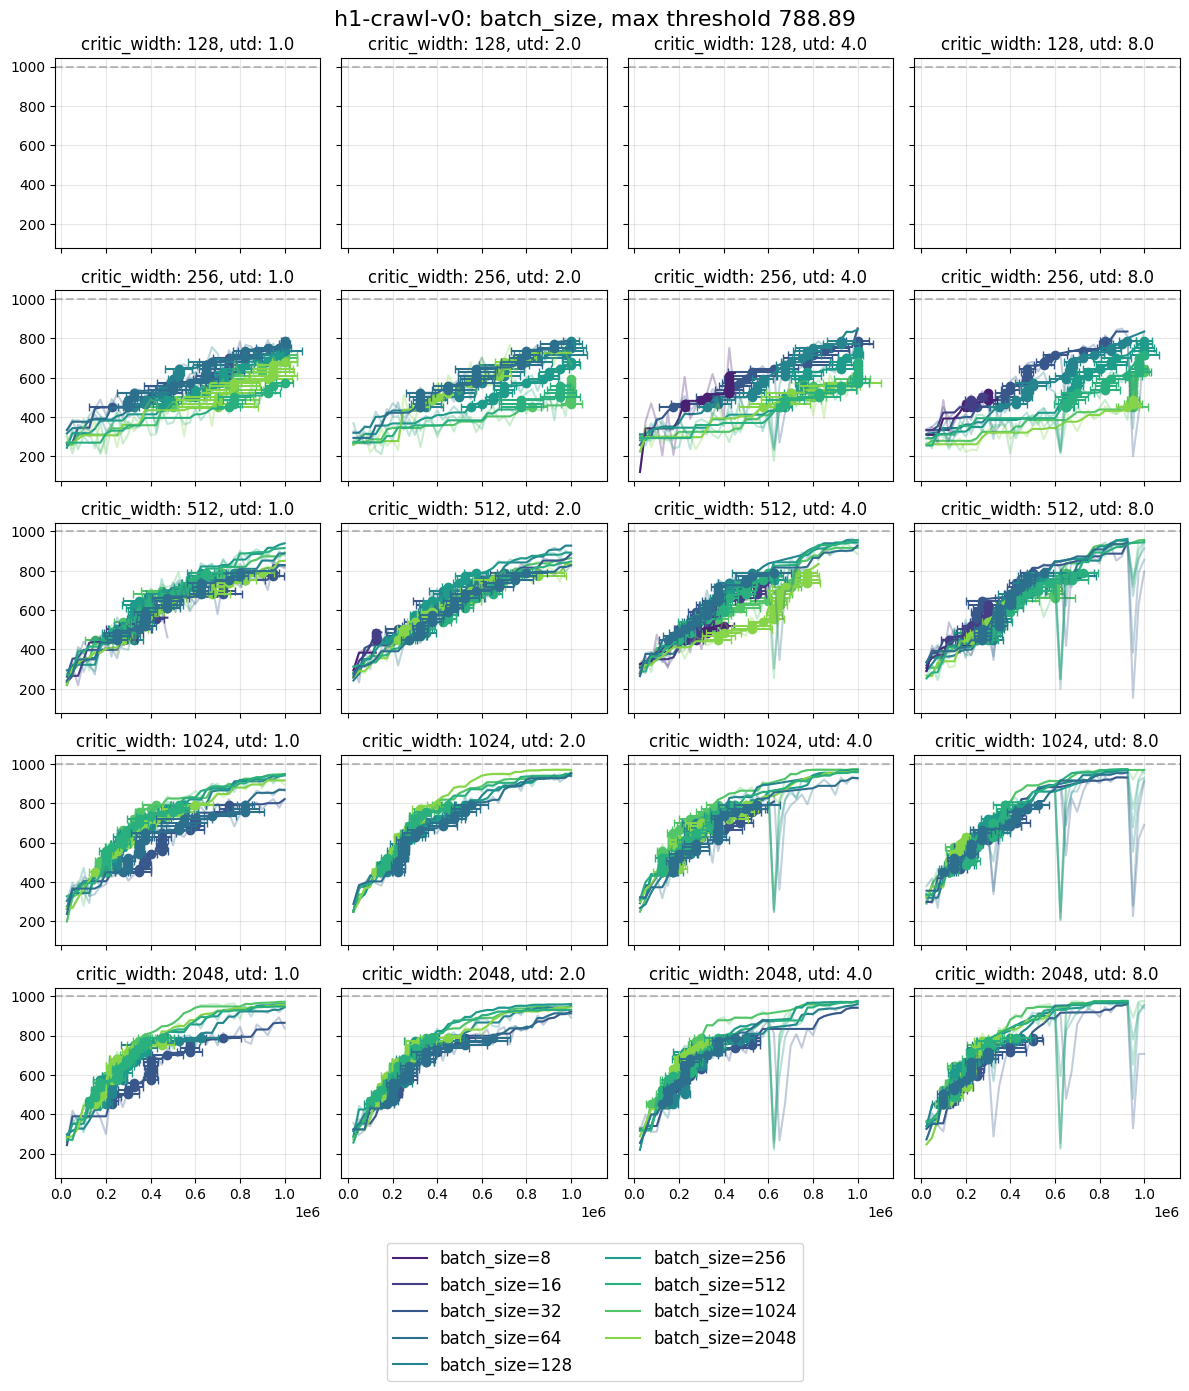

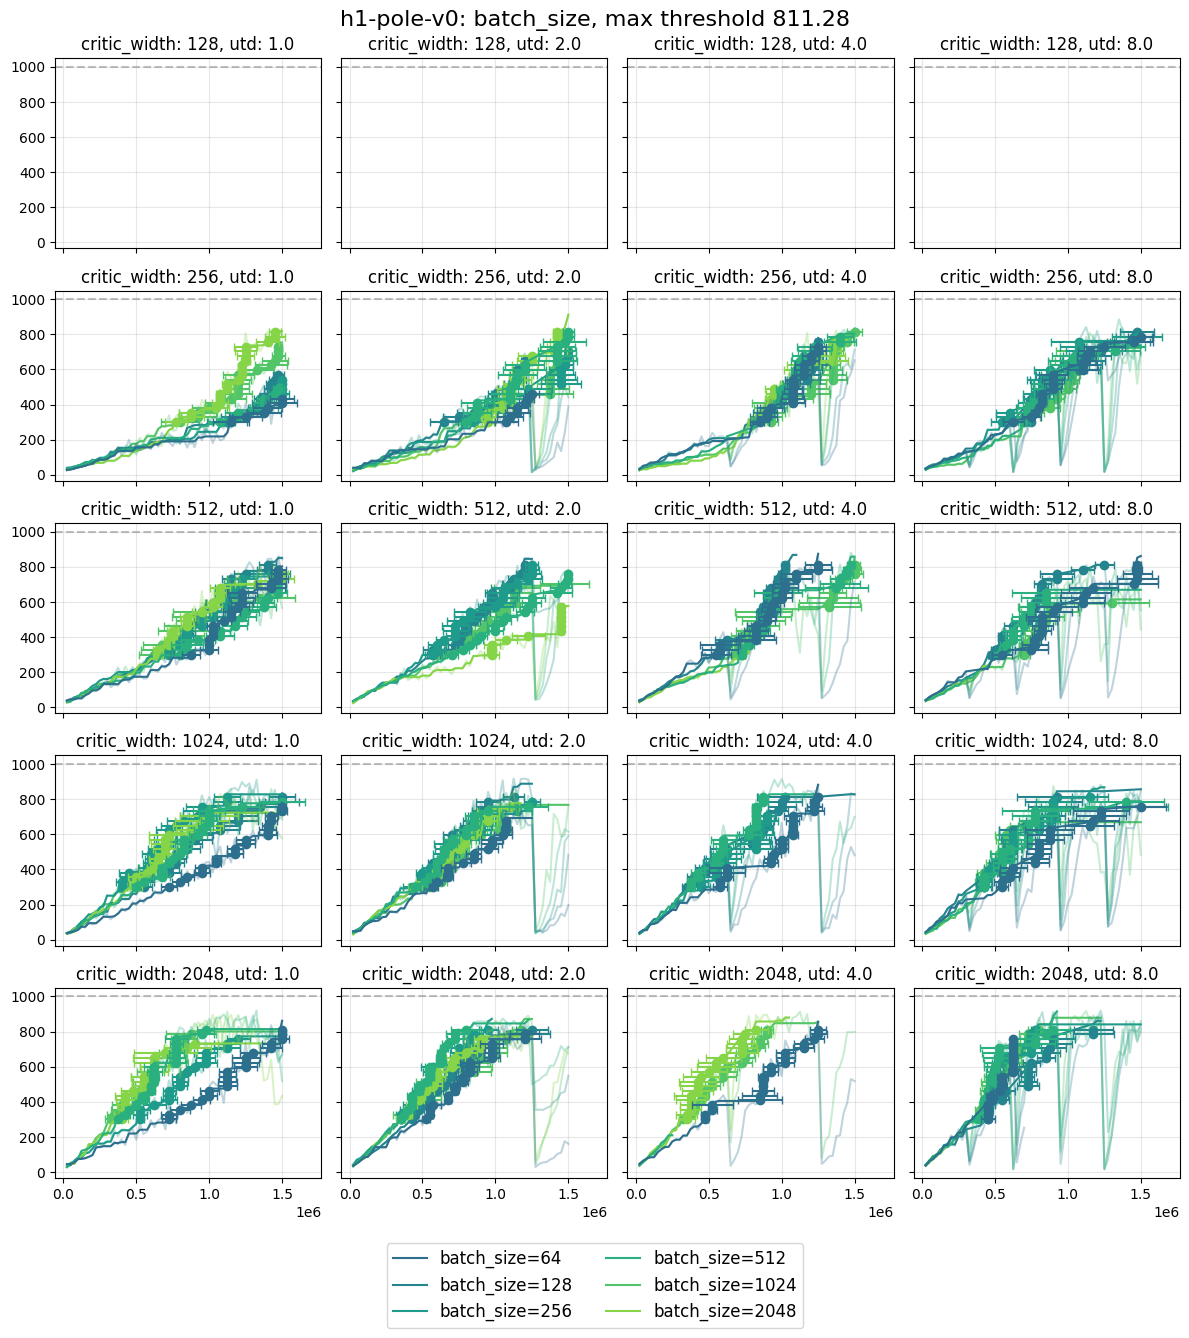

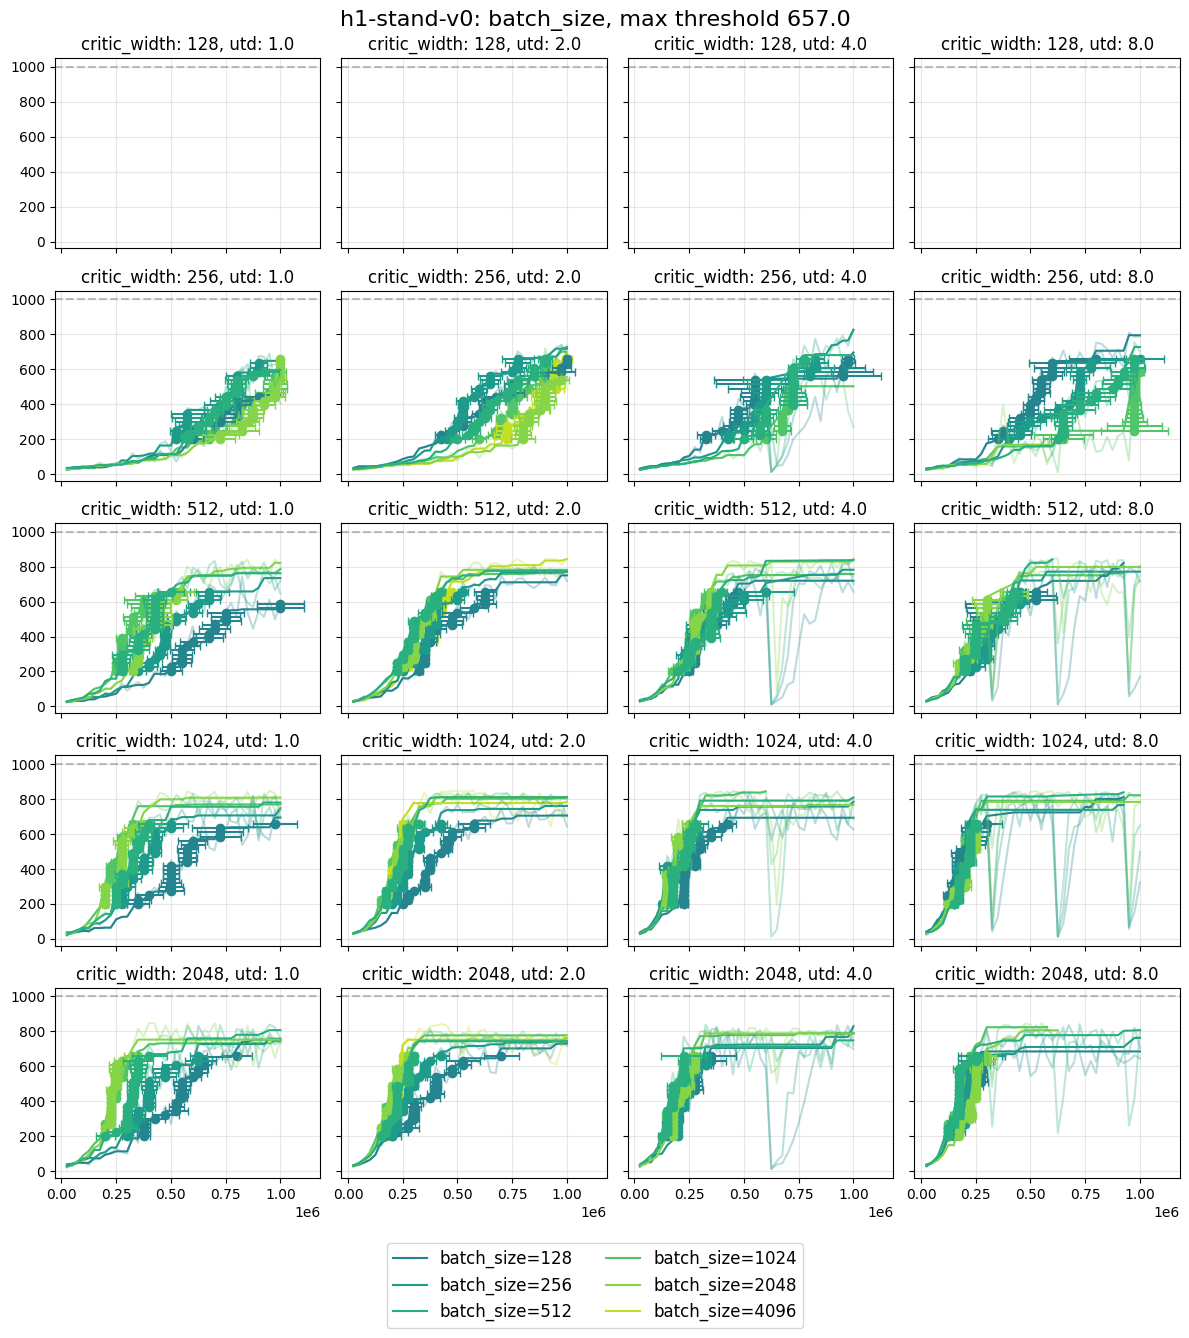

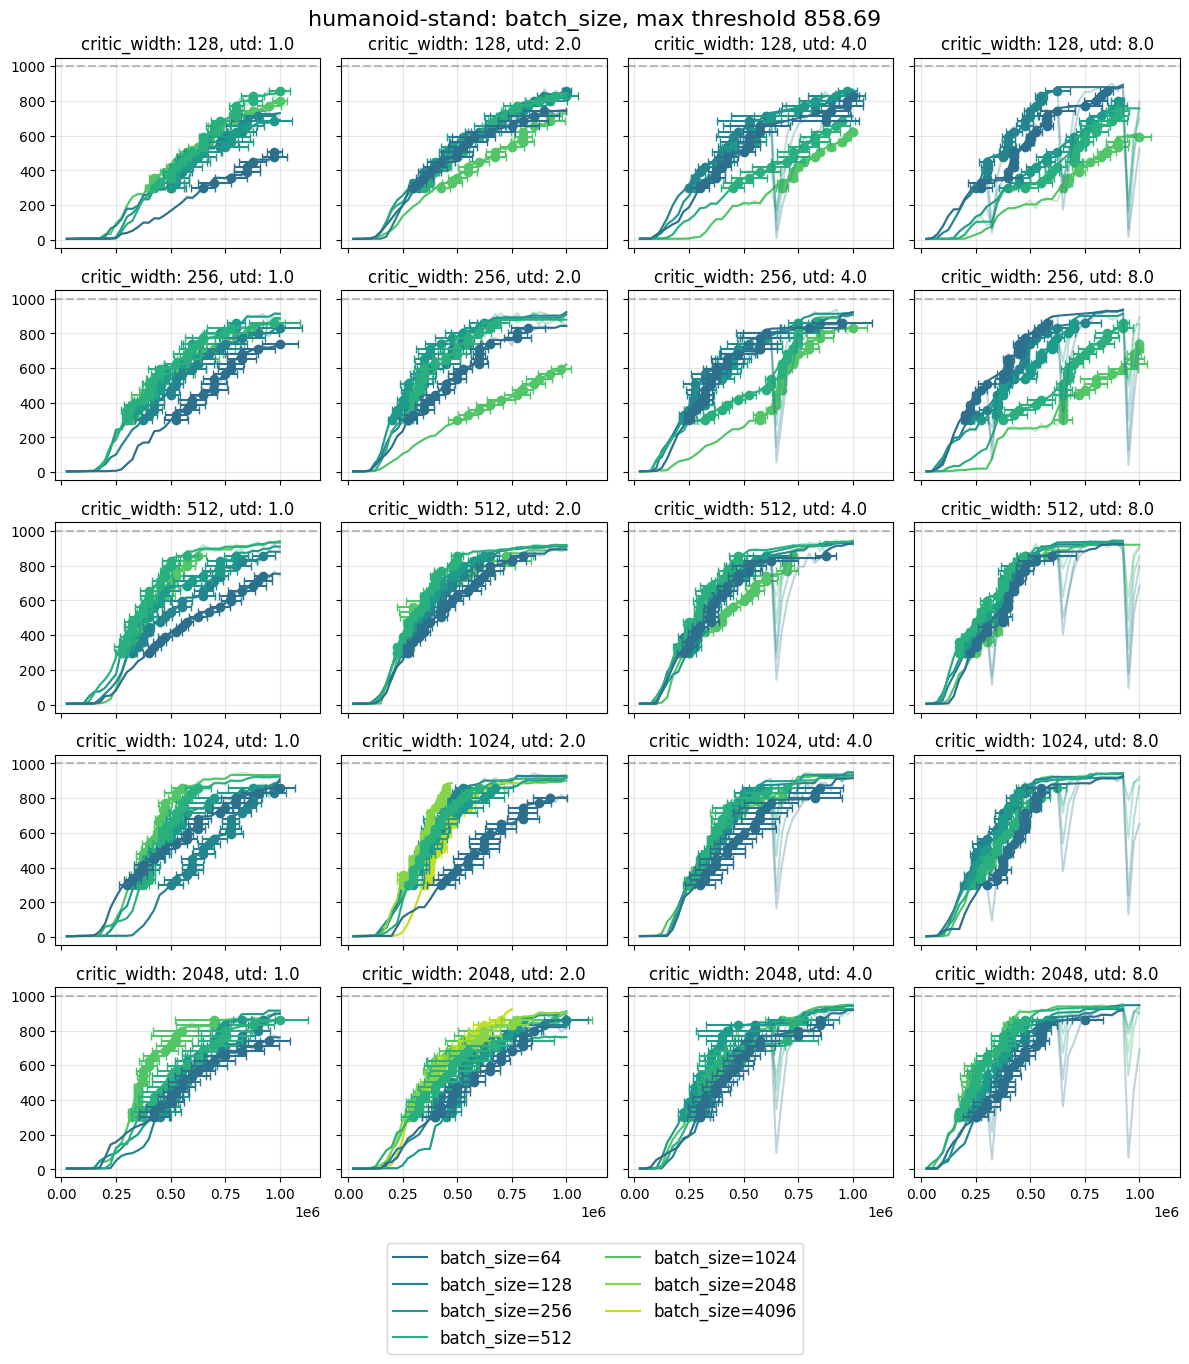

In [16]:
plot_utils.plot_learning_curves_with_thresholds(df, 'batch_size', thresholds_per_env)

# Figure 5: Bootstrapped optimal batch size

In [17]:
def assign_batch_size_uncertainty(df, threshold_idx=-1, goodness_criteria='overlap'):
    complete_sweep = df.groupby(['env_name', 'critic_width', 'utd'])['batch_size'].count()
    valid_groups = complete_sweep[complete_sweep >= 3].index
    complete_sweep_df = (
        df.set_index(['env_name', 'critic_width', 'utd']).loc[valid_groups].reset_index()
    )
    best_bs = grid_best_uncertainty_bs(
        complete_sweep_df, threshold_idx, goodness_criteria=goodness_criteria
    )
    best_bs['good_enough_bs_ratio'] = (
        best_bs['largest_bs_good_enough'] / best_bs['smallest_bs_good_enough']
    )
    return best_bs


best_bs_key = 'best_bs_bootstrap_mean'
best_bs = assign_batch_size_uncertainty(df, goodness_criteria='overlap')

df_with_best_bs_subset = pd.merge(
    df,
    best_bs,
    left_on=['env_name', 'critic_width', 'critic_params', 'utd', 'batch_size', 'learning_rate'],
    right_on=['env_name', 'critic_width', 'critic_params', 'utd', 'best_bs', 'learning_rate'],
)

In [18]:
xcols = ['utd', 'critic_params']

best_bs_with_fit, params_dict_product = insert_predictions_inverse_power_product_log_normalize(
    df_with_best_bs_subset,
    xcols,
    best_bs_key,
    name=config.name,
    use_cached=True,
    log_loss=True,
)

predict_inverse_power_product_log_normalize_ = (
    lambda df: predict_inverse_power_product_log_normalize(df, xcols, params_dict_product)
)

upward_asymptotes_product = {
    (k, utd): params[0] / utd ** params[3]
    for k, params in params_dict_product.items()
    for utd in df['utd'].unique()
}

upward_asymptotes_params_df = pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'b': params[1],
            'c': params[2],
            'alpha': params[3],
            'a_unscaled': params[4],
            'b_unscaled': params[5],
            'c_unscaled': params[6],
        }
        for k, params in params_dict_product.items()
    ]
)

Loaded params from /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base/utd_critic_params_best_bs_bootstrap_mean_inverse_power_product.npy


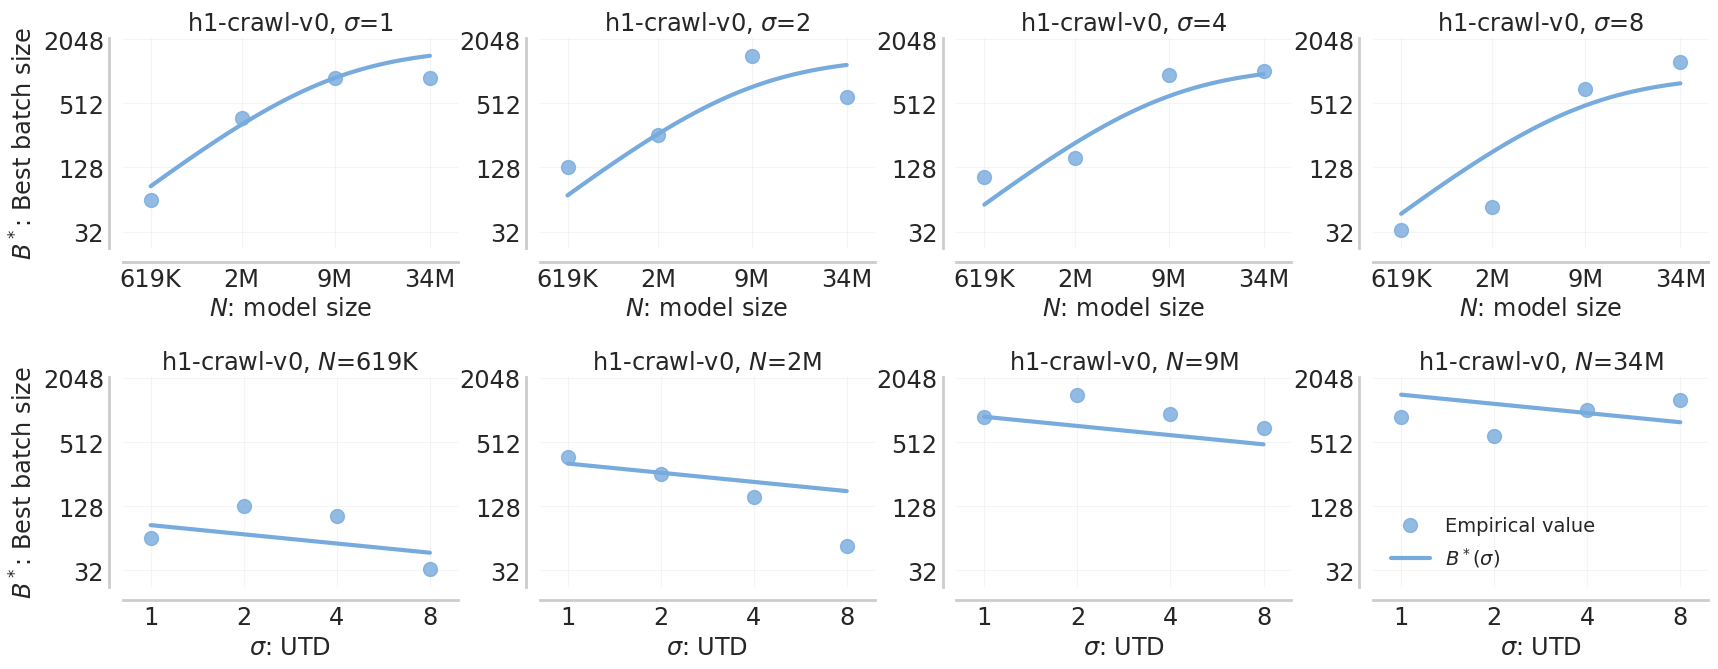

In [19]:
plot_optimal_hparam_fit_per_env_combined_pretty(
    best_bs_with_fit.query('env_name == "h1-crawl-v0"'),
    best_bs_key,
    'best_bs_bootstrap_std',
    'there is actually no title',
    [
        (
            predict_inverse_power_product_log_normalize_,
            {'color': 'qscaled_1', 'label': '$B^*(\sigma)$'},
        ),
    ],
    yscale='log2',
    hard_ymax=2048,
    hard_ymin=8,
)

# Data efficiency fits

In [20]:
best_bs_df_for_data_fits = best_bs_with_fit

for desc, df_ in [
    ('original', best_bs_with_fit),
    ('interpolated', interpolated_bs_df),
    ('extrapolated', extrapolated_bs_df),
    ('fitted_bs', fitted_bs_runs_df),
    ('compute_optimal', compute_optimal_df),
    ('utd_scaling_bl', compute_utd_scaling_bl_df),
    ('n_scaling_bl', compute_n_scaling_bl_df),
]:
    df_['time_to_threshold'] = df_['crossings'].apply(lambda x: x[-1])
    df_['time_to_threshold_bootstrap'] = df_['crossings_bootstrap'].apply(lambda x: x[-1])
    df_['time_to_threshold_std'] = df_['time_to_threshold_bootstrap'].apply(
        lambda x: np.nanstd(x[x < np.inf], ddof=0)
    )
    df_['best_bs'] = df_['batch_size']
    df_['type'] = desc

/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [21]:
def concat_interpolated_for_data_fits(
    best_bs_df_for_data_fits,
    interpolated_bs_df=None,
    extrapolated_bs_df=None,
    fitted_bs_runs_df=None,
):
    best_bs_df_for_data_fits = deepcopy(best_bs_df_for_data_fits)
    ls = [best_bs_df_for_data_fits]
    best_bs_df_for_data_fits['type'] = 'original'
    for type, df_ in [
        ('interpolated', interpolated_bs_df),
        ('extrapolated', extrapolated_bs_df),
        ('fitted_bs', fitted_bs_runs_df),
    ]:
        if df_ is None:
            continue
        df_ = deepcopy(df_)
        df_['best_bs'] = df_['batch_size']
        df_ = df_[[c for c in best_bs_df_for_data_fits.columns if c in df_.columns]]
        df_['type'] = type
        ls.append(df_)
    return pd.concat(ls)


best_bs_df_for_data_fits = concat_interpolated_for_data_fits(
    best_bs_df_for_data_fits, interpolated_bs_df, extrapolated_bs_df, fitted_bs_runs_df
)

In [22]:
best_bs_df_for_data_fits, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
    best_bs_df_for_data_fits,
    xcols,
    'time_to_threshold',
    name=config.name,
    use_cached=False,
    log_loss=True,
)

predict_data_efficiency_sum_powerlaw_ = lambda df: predict_sum_of_powerlaw(
    df, xcols, time_to_thresh_sum_powerlaw_params
)

data_efficiency_sum_powerlaw_asymptotes_utd = {
    (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for utd in set(df['utd'].unique())
    | set(interpolated_bs_df['utd'].unique())
    | set(extrapolated_bs_df['utd'].unique())
    | set(compute_optimal_df['utd'].unique())
    | set(fitted_bs_runs_df['utd'].unique())
}

data_efficiency_sum_powerlaw_asymptotes_n = {
    (k, n): params[4] * (1 + (params[2] / n) ** params[3])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for n in set(df['critic_params'].unique())
    | set(interpolated_bs_df['critic_params'].unique())
    | set(extrapolated_bs_df['critic_params'].unique())
    | set(compute_optimal_df['critic_params'].unique())
    | set(fitted_bs_runs_df['critic_params'].unique())
}

data_efficiency_sum_powerlaw_params_df = pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'alpha': params[1],
            'b': params[2],
            'beta': params[3],
            'c': params[4],
            'alpha_unscaled': params[5],
            'beta_unscaled': params[6],
            'a_unscaled': params[7],
            'b_unscaled': params[8],
            'c_unscaled': params[9],
        }
        for k, params in time_to_thresh_sum_powerlaw_params.items()
    ]
)

Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base/utd_critic_params_time_to_threshold_sum_powerlaw.npy


## Figure 6: Data efficiency fit on multiple domains

In [23]:
dmc_medium_averaged_params_sets = np.load(
    '../saved_fits/dmc_multiple_thresholds_250522.npy',
    allow_pickle=True,
)
dmc_hard_averaged_params_sets = np.load(
    '../saved_fits/dog_humanoid_multiple_thresholds_250522.npy',
    allow_pickle=True,
)
simba_params = np.load(
    '../fits/simbav2_model_scaling_linear20_with_base/utd_critic_params_time_to_threshold_sum_powerlaw.npy',
    allow_pickle=True,
).item()

dmc_medium_last_threshold_df = pd.read_csv('../saved_fits/dmc_last_threshold_250522.csv')
dmc_hard_last_threshold_df = pd.read_csv('../saved_fits/dog_humanoid_last_threshold_250522.csv')
simba_df = pd.read_csv('../saved_fits/simba_250823.csv')

dmc_medium_last_threshold_df['time_to_threshold'] = dmc_medium_last_threshold_df['time']
dmc_hard_last_threshold_df['time_to_threshold'] = dmc_hard_last_threshold_df['time']

dmc_medium_last_threshold_df['env_name'] = 'DMC-medium'
dmc_hard_last_threshold_df['env_name'] = 'DMC-hard'
simba_df['env_name'] = simba_df['env_name'].apply(lambda x: x + 'simba')

dmc_medium_highest_threshold_params = dmc_medium_averaged_params_sets[-1]['sum_powerlaw']
time_to_thresh_sum_powerlaw_params['DMC-medium'] = dmc_medium_highest_threshold_params['']

dmc_hard_highest_threshold_params = dmc_hard_averaged_params_sets[-1]['sum_powerlaw']
time_to_thresh_sum_powerlaw_params['DMC-hard'] = dmc_hard_highest_threshold_params['']

time_to_thresh_sum_powerlaw_params.update(
    {env + 'simba': params for env, params in simba_params.items()}
)

predict_data_efficiency_sum_powerlaw_ = lambda df: predict_sum_of_powerlaw(
    df, xcols, time_to_thresh_sum_powerlaw_params
)

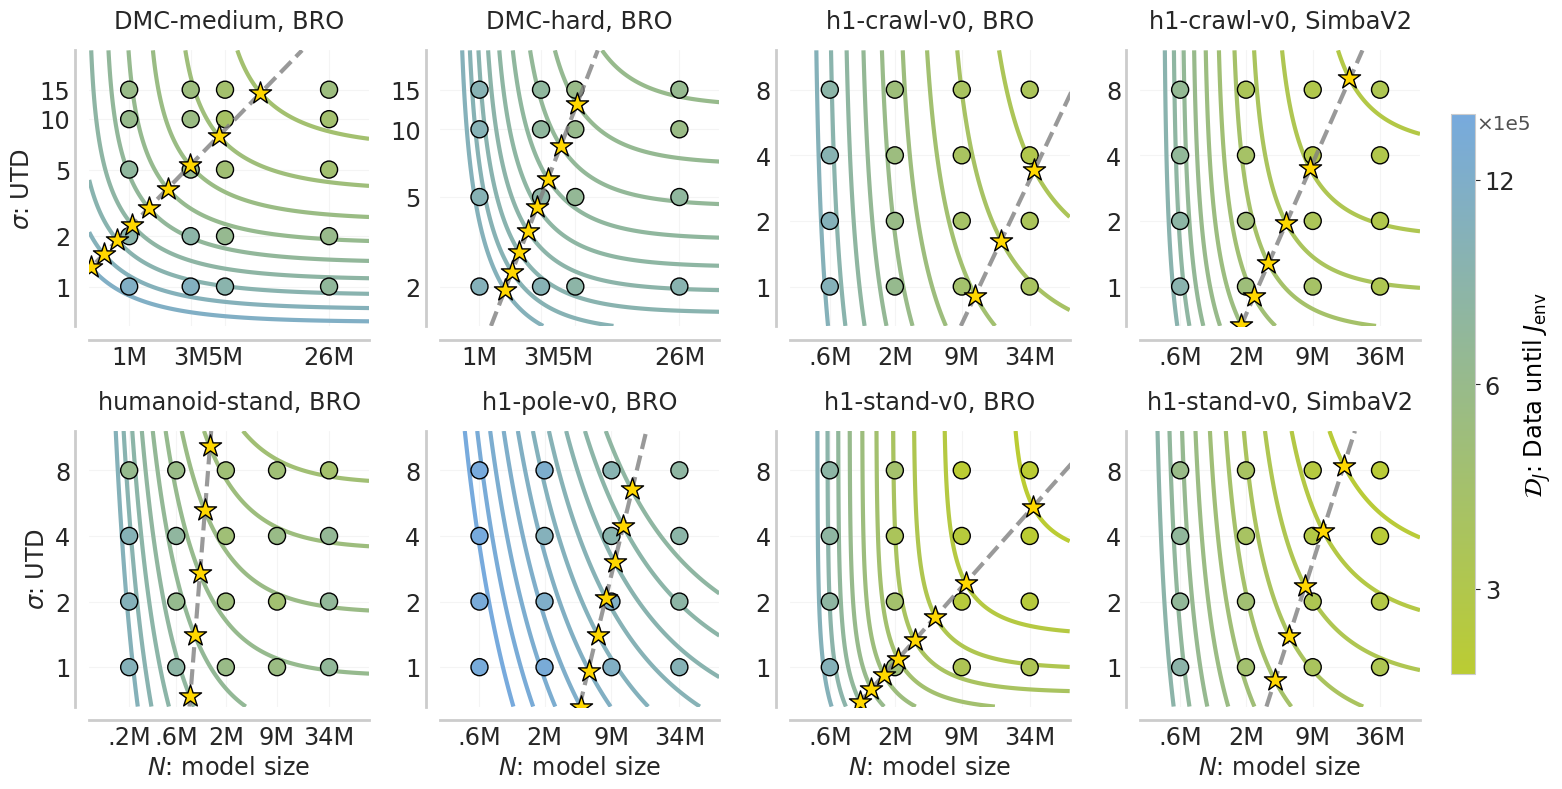

In [24]:
_ = plot_utils.plot_optimal_hparams_scatter_pretty(
    df=pd.concat(
        [
            best_bs_df_for_data_fits.query('type == "original"'),
            dmc_medium_last_threshold_df,
            dmc_hard_last_threshold_df,
            simba_df,
        ]
    ),
    predict_fn=predict_data_efficiency_sum_powerlaw_,
    data_efficiency_key='time_to_threshold',
    mode='data_contour',
    show_optima_as_stars=True,
    show_cost_contour=False,
    params=time_to_thresh_sum_powerlaw_params,
    cbar_ticks=[3e5, 6e5, 12e5],
    cbar_scale='1e5',
)

## Section 7.1: Data efficiency fit evaluation

In [ ]:
def check_fit_accuracy(labels_dfs, pred_fn):
    for type, df_ in labels_dfs:
        pred = pred_fn(df_)
        true = df_['time_to_threshold']
        print(f'{type} error: {np.mean(np.abs(pred - true) / true)}')


check_fit_accuracy(
    [
        ('original', best_bs_with_fit),
        ('interpolated', interpolated_bs_df),
        ('extrapolated', extrapolated_bs_df),
        ('compute_optimal', compute_optimal_df),
    ],
    predict_data_efficiency_sum_powerlaw_,
)

original error: 0.08702257736129819
interpolated error: 0.10948692497654004
extrapolated error: 0.1208342821328909
compute_optimal error: 0.10707978024465269


## Figures 16, 17: Data efficiency fits for multiple $J$

In [26]:
generic_fit_infos = {
    'sum_powerlaw': {
        'color': 'tab:purple',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
    },
}


def make_multiple_crossings_df(df):
    df = deepcopy(df)
    df['best_bs'] = df['batch_size']
    multiple_crossings_df = df[
        [
            'env_name',
            'critic_width',
            'critic_params',
            'utd',
            'best_bs',
            'learning_rate',
            'training_step_resetfilter',
            'return_isotonic',
            'return_isotonic_std',
            'crossings',
            'crossings_bootstrap',
            'type',
        ]
    ]
    for df_ in [multiple_crossings_df]:
        df_['crossings_std'] = df_['crossings_bootstrap'].apply(
            lambda x: np.nanstd(x, axis=0, ddof=0)
        )
        for i in range(n_thresholds):
            df_[f'crossing{i}'] = df_['crossings'].apply(lambda x: x[i])
            try:
                df_[f'crossing{i}_std'] = df_['crossings_std'].apply(lambda x: x[i])
            except:
                print(df_['crossings_std'])
                raise
        df_['time_to_threshold'] = df_[f'crossing{n_thresholds - 1}']

    return multiple_crossings_df


multiple_crossings_df = make_multiple_crossings_df(best_bs_df_for_data_fits)
time_to_thresholds_predictors = [{} for _ in range(n_thresholds)]
time_to_thresholds_infos_utd = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]
time_to_thresholds_infos_n = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]

multiple_crossings_state = (
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
)

/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [27]:
def insert_multiple_sum_powerlaw(state, use_cached):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_powerlaw'
    kw = dict(use_cached=use_cached, log_loss=True, save_params=False)

    for i in tqdm(range(n_thresholds)):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            multiple_crossings_df, xcols, f'crossing{i}', name=f'{config.name}_crossing{i}', **kw
        )

        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in set(df['utd'].unique())
            | set(interpolated_bs_df['utd'].unique())
            | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in set(df['critic_params'].unique())
            | set(interpolated_bs_df['critic_params'].unique())
            | set(extrapolated_bs_df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_
        infos_utd[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_utd
        infos_n[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_n
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


(
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
) = insert_multiple_sum_powerlaw(multiple_crossings_state, use_cached=False)

  5%|▌         | 1/20 [00:00<00:04,  3.82it/s]

100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


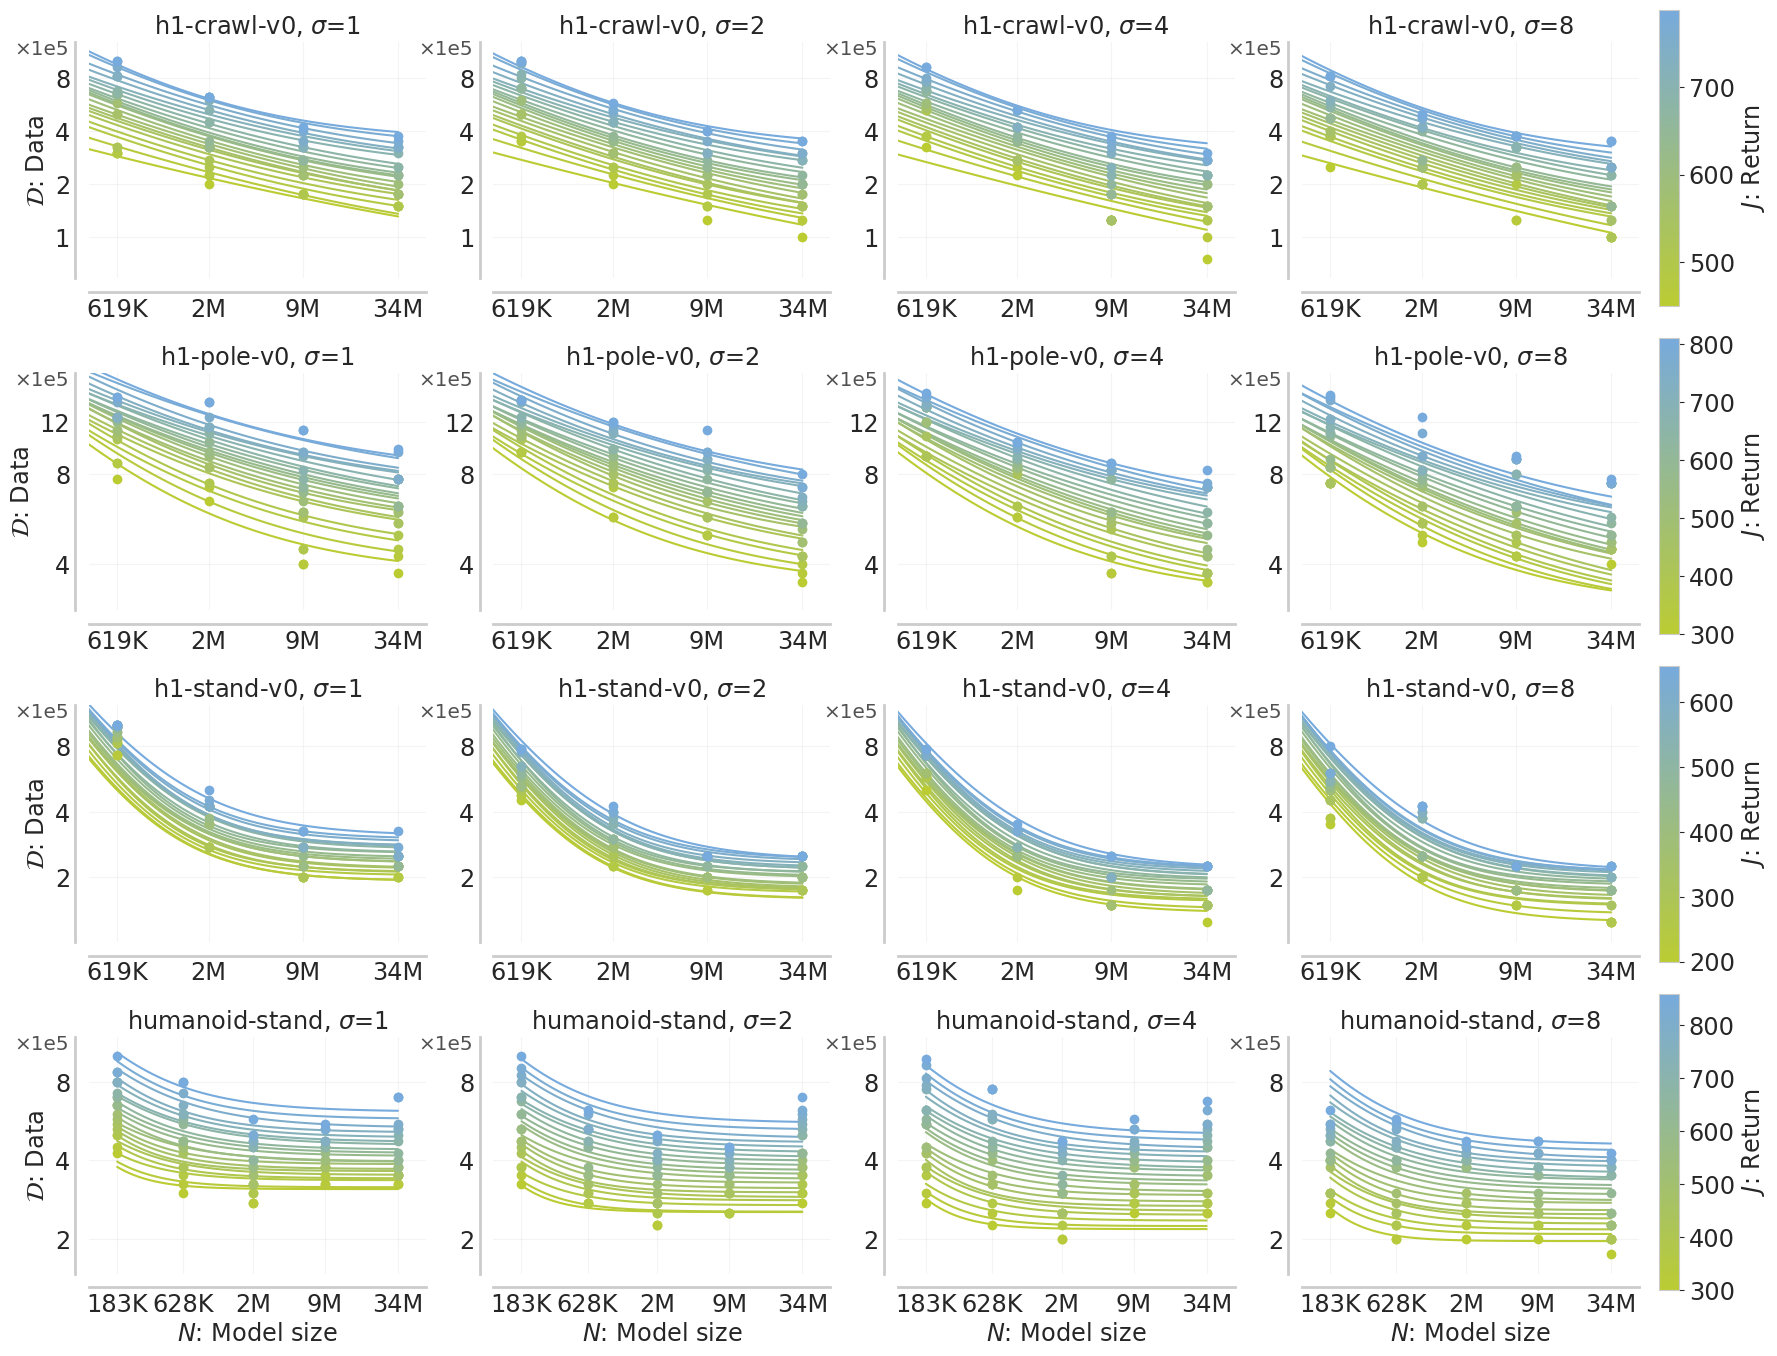

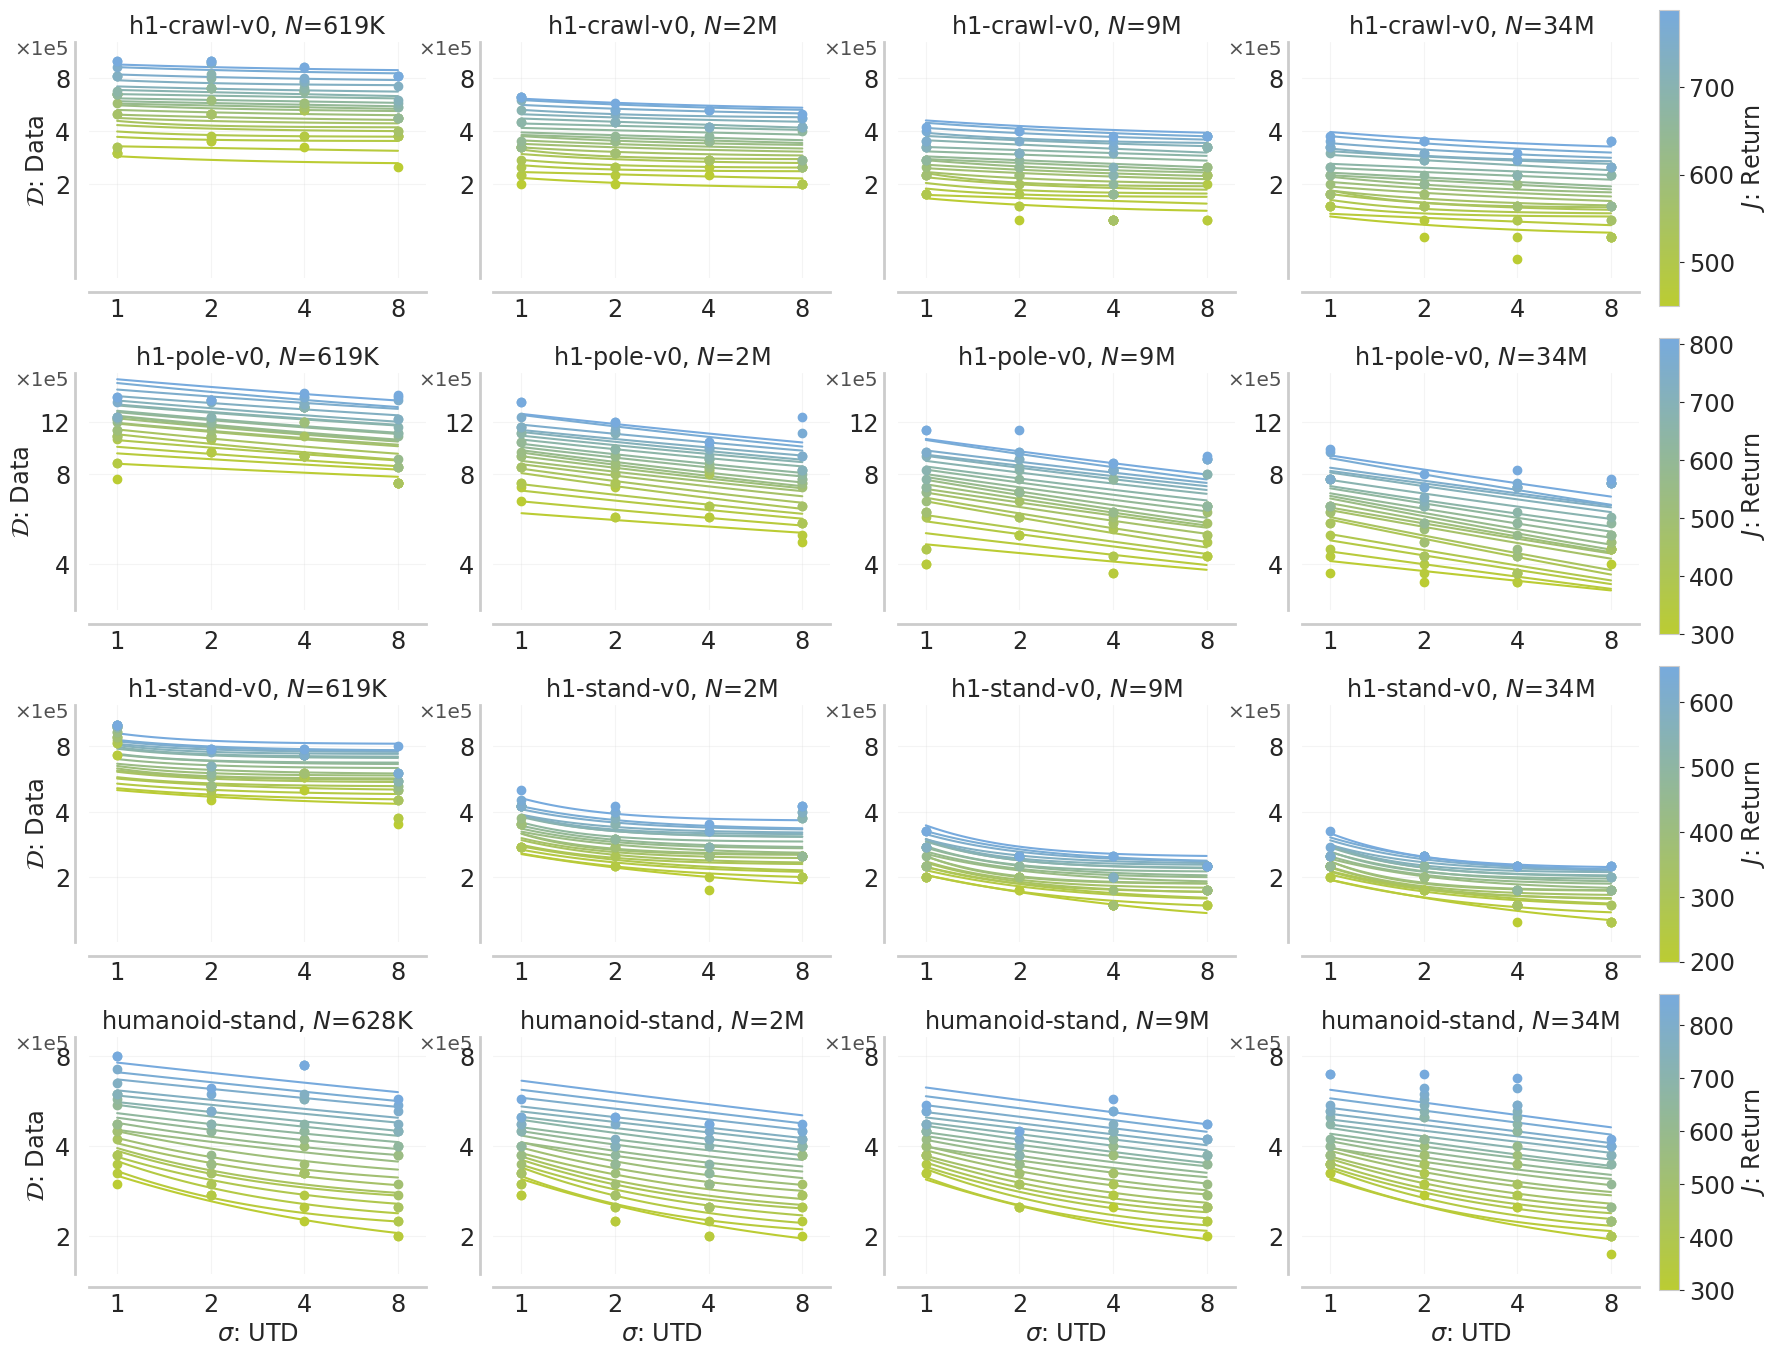

In [28]:
def plot_multiple_data_efficiency(multiple_crossings_state, fit_type):
    (
        multiple_crossings_df,
        time_to_thresholds_predictors,
        time_to_thresholds_infos_utd,
        time_to_thresholds_infos_n,
    ) = multiple_crossings_state

    multiple_crossings_df = multiple_crossings_df.query('type == "original"')
    multiple_crossings_df['batch_size'] = multiple_crossings_df['best_bs']
    dfs_list = []
    for i in range(n_thresholds):
        cols = [
            'env_name',
            'critic_width',
            'critic_params',
            'utd',
            'batch_size',
            f'crossing{i}',
            f'crossing{i}_std',
        ]
        dfs_list.append(
            multiple_crossings_df[cols].rename(
                columns={f'crossing{i}': 'time', f'crossing{i}_std': 'time_std'}
            )
        )

    plot_optimal_hparam_fit_per_env_utd_multiple_thresh_pretty(
        dfs_list,
        'time',
        'time_std',
        'Time to threshold',
        thresholds_per_env,
        [
            (time_to_thresholds_predictors[i][fit_type], time_to_thresholds_infos_utd[i][fit_type])
            for i in range(n_thresholds)
        ],
        yticks={
            'h1-crawl-v0': [1e5, 2e5, 4e5, 8e5],
            'h1-pole-v0': [4e5, 8e5, 12e5],
            'h1-stand-v0': [2e5, 4e5, 8e5],
            'humanoid-stand': [2e5, 4e5, 8e5],
        },
    )

    plot_optimal_hparam_fit_per_env_n_multiple_thresh_pretty(
        [x.query('critic_width >= 256') for x in dfs_list],
        'time',
        'time_std',
        'Time to threshold',
        thresholds_per_env,
        [
            (time_to_thresholds_predictors[i][fit_type], time_to_thresholds_infos_utd[i][fit_type])
            for i in range(n_thresholds)
        ],
        yticks={
            'h1-crawl-v0': [2e5, 4e5, 8e5],
            'h1-pole-v0': [4e5, 8e5, 12e5],
            'h1-stand-v0': [2e5, 4e5, 8e5],
            'humanoid-stand': [2e5, 4e5, 8e5],
        },
        group_col='critic_width',
    )


plot_multiple_data_efficiency(multiple_crossings_state, 'sum_powerlaw')

# Section 7.2: Budget-optimal resource allocation

In [29]:
delta_dict = {
    'h1-crawl-v0': '2e12',
    'h1-stand-v0': '5e11',
    'h1-pole-v0': '5e11',
    'humanoid-stand': '5e10',
}


def compute_multiple_optimal_budget(multiple_crossings_df, param_sets, delta_dict):
    results = []
    for env, group in multiple_crossings_df.groupby('env_name'):
        delta_str = delta_dict[env]
        env_hparams = plot_utils.compute_optimal_budget(
            group,
            params_per_thresh=[
                param_sets[i]['sum_powerlaw']['params'] for i in range(n_thresholds)
            ],
            data_efficiency_key_prefix='crossing',
            delta=float(delta_str),
        )
        results.append(env_hparams)
    return pd.concat(results)


multiple_budget_optimal_hparams = compute_multiple_optimal_budget(
    multiple_crossings_df.query('type=="fitted_bs"'),
    time_to_thresholds_infos_utd,
    delta_dict,
)

100%|██████████| 20/20 [00:00<00:00, 429.18it/s]


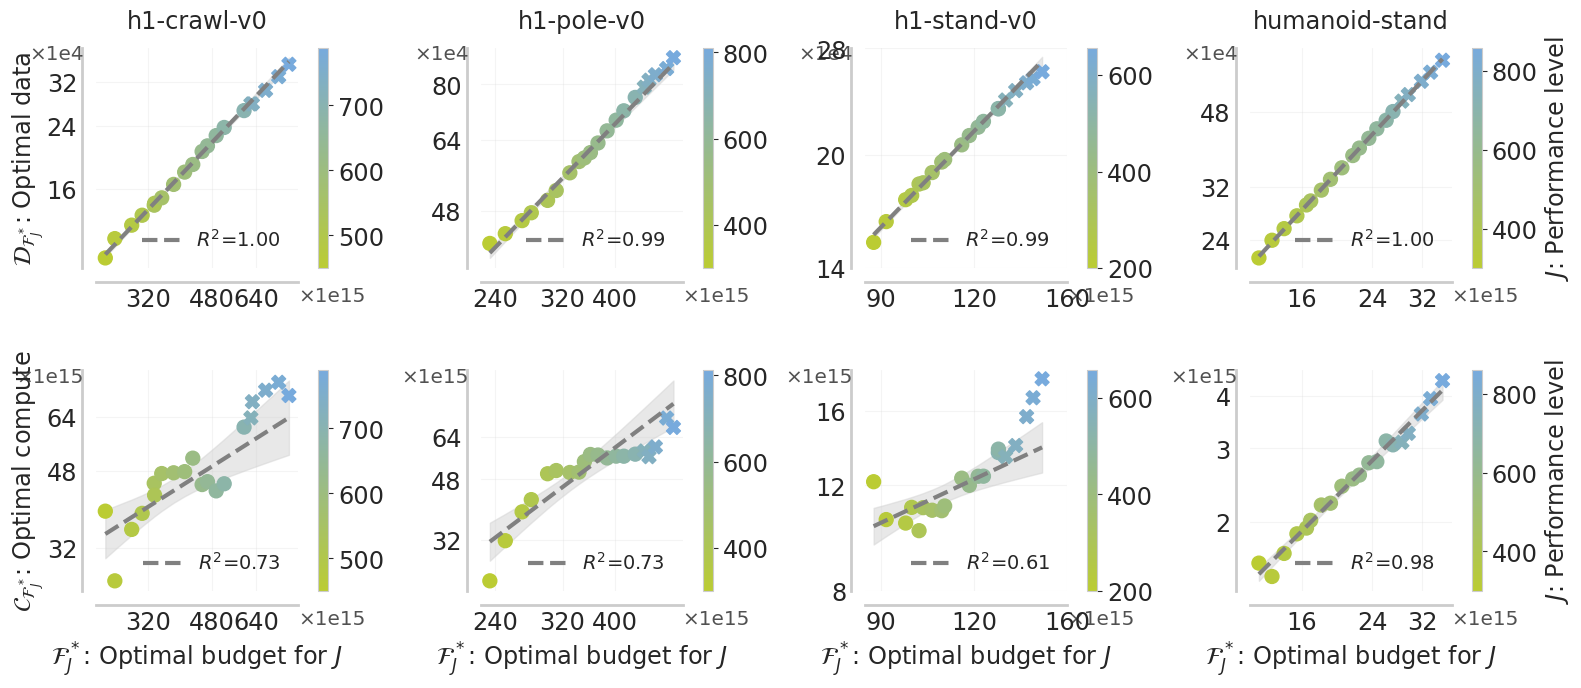

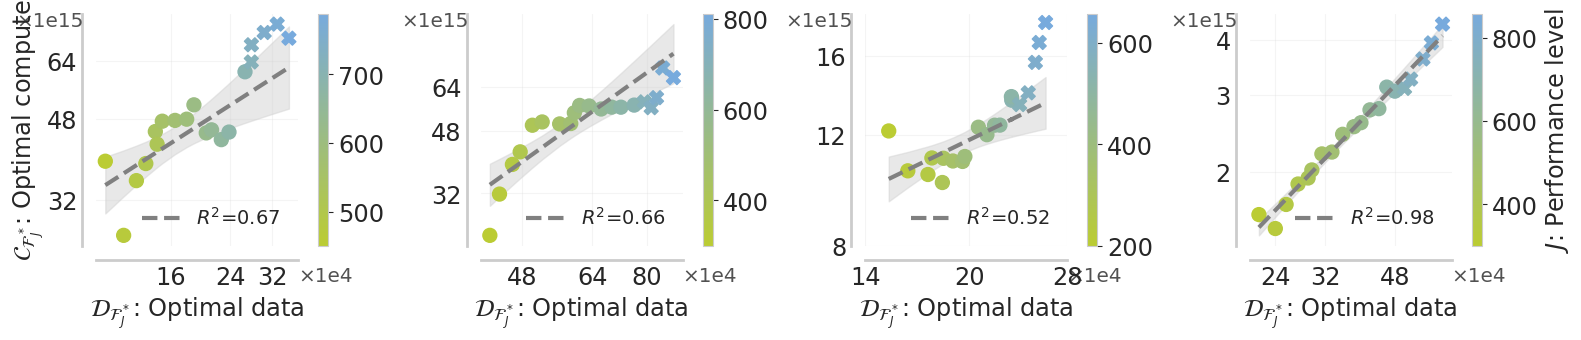

In [30]:
plot_utils.plot_budget_data_compute_opt_pretty(
    multiple_budget_optimal_hparams,
    delta_dict,
    thresholds_per_env,
    xticks={
        'h1-crawl-v0': [32e16, 48e16, 64e16],
        'h1-pole-v0': [24e16, 32e16, 40e16],
        'h1-stand-v0': [9e16, 12e16, 16e16],
        'humanoid-stand': [1.6e16, 2.4e16, 3.2e16],
    },
    xscale='1e15',
    data_yticks={
        'h1-crawl-v0': [16e4, 24e4, 32e4],
        'h1-pole-v0': [48e4, 64e4, 80e4],
        'h1-stand-v0': [14e4, 20e4, 28e4],
        'humanoid-stand': [24e4, 32e4, 48e4],
    },
    data_yscale='1e4',
    compute_yticks={
        'h1-crawl-v0': [32e15, 48e15, 64e15],
        'h1-pole-v0': [32e15, 48e15, 64e15],
        'h1-stand-v0': [8e15, 12e15, 16e15],
        'humanoid-stand': [2e15, 3e15, 4e15],
    },
    compute_yscale='1e15',
    num_extrapolated_points=5,
)

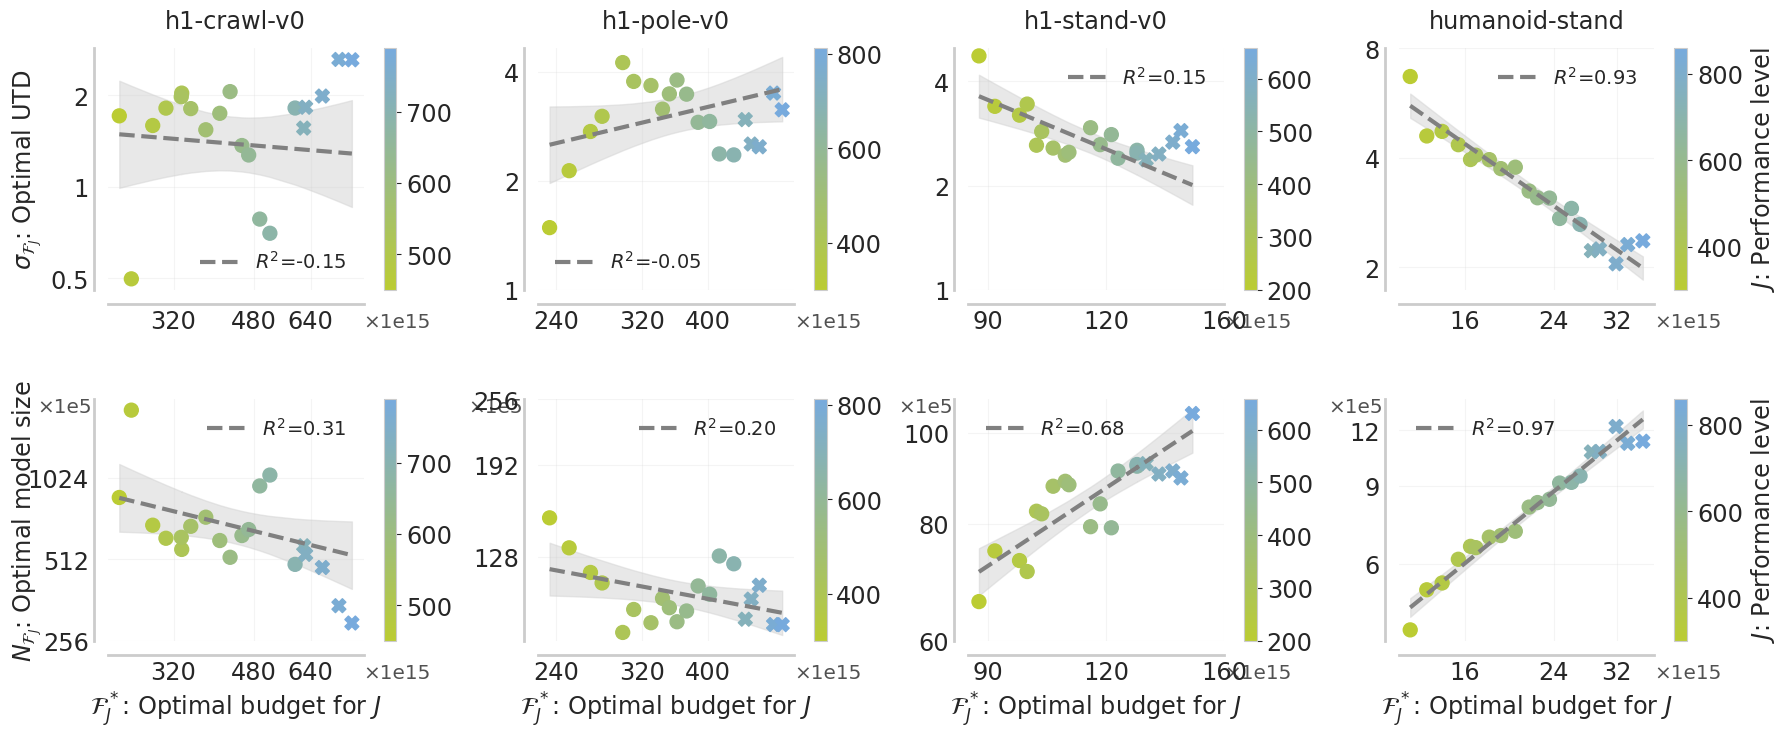

In [31]:
plot_utils.plot_budget_n_sigma_opt_pretty(
    multiple_budget_optimal_hparams,
    delta_dict,
    thresholds_per_env,
    xticks={
        'h1-crawl-v0': [32e16, 48e16, 64e16],
        'h1-pole-v0': [24e16, 32e16, 40e16],
        'h1-stand-v0': [9e16, 12e16, 16e16],
        'humanoid-stand': [1.6e16, 2.4e16, 3.2e16],
    },
    xscale='1e15',
    sigma_yticks={
        'h1-crawl-v0': [0.5, 1.0, 2.0],
        'h1-pole-v0': [1.0, 2.0, 4.0],
        'h1-stand-v0': [1.0, 2.0, 4.0],
        'humanoid-stand': [2.0, 4.0, 8.0],
    },
    sigma_yscale='1',
    n_yticks={
        'h1-crawl-v0': [256e5, 512e5, 1024e5],
        'h1-pole-v0': [128e5, 192e5, 256e5],
        'h1-stand-v0': [60e5, 80e5, 100e5],
        'humanoid-stand': [6e5, 9e5, 12e5],
    },
    n_yscale='1e5',
    num_extrapolated_points=5,
)

# Table 2: Compute allocation comparison

In [32]:
compute_optimal_df['type'] = 'compute_optimal'
compute_utd_scaling_bl_df['type'] = 'utd_scaling_bl'
compute_n_scaling_bl_df['type'] = 'n_scaling_bl'
compute_optimal_multiple_crossings_df = make_multiple_crossings_df(compute_optimal_df)
utd_scaling_bl_multiple_crossings_df = make_multiple_crossings_df(compute_utd_scaling_bl_df)
n_scaling_bl_multiple_crossings_df = make_multiple_crossings_df(compute_n_scaling_bl_df)

/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [33]:
def compare_compute_optimal_to_baselines(
    compute_optimal_multiple_crossings_df,
    utd_scaling_bl_multiple_crossings_df,
    n_scaling_bl_multiple_crossings_df,
):
    compute_optimal_hparams = pd.read_csv('proposed_hparams/hb_compute_optimal_250509.csv')
    utd_scaling_hparams = pd.read_csv('proposed_hparams/hb_utd_scaling_250531.csv')
    n_scaling_hparams = pd.read_csv('proposed_hparams/hb_n_scaling_250531.csv')
    budget_col = 'compute_budget'
    merge_cols = ['env_name', budget_col]

    def merge(multiple_crossings_df, hparams):
        types = multiple_crossings_df['type'].unique()
        assert len(types) == 1
        suffix = types[0]
        cs = ['env_name', 'utd', 'critic_width']
        df = pd.merge(
            multiple_crossings_df,
            hparams[[*cs, 'batch_size_rounded', budget_col]],
            left_on=[*cs, 'best_bs'],
            right_on=[*cs, 'batch_size_rounded'],
        )
        return df.add_suffix('_' + suffix).rename(columns={f'{c}_{suffix}': c for c in merge_cols})

    optimal = merge(compute_optimal_multiple_crossings_df, compute_optimal_hparams)
    utd_scaled = merge(utd_scaling_bl_multiple_crossings_df, utd_scaling_hparams)
    n_scaled = merge(n_scaling_bl_multiple_crossings_df, n_scaling_hparams)
    result = optimal.merge(utd_scaled, on=['env_name', budget_col], how='outer').merge(
        n_scaled, on=['env_name', budget_col], how='outer'
    )

    return result


def analyze_compute_alloc(compute_alloc_comparison_df, metrics=['time_to_threshold']):
    categories = ['compute_optimal', 'utd_scaling_bl', 'n_scaling_bl']
    envs = compute_alloc_comparison_df['env_name'].unique()

    def prepare_data(agg_data):
        result = (agg_data / agg_data[metric + '_compute_optimal']).to_dict()
        result = {k.replace(metric + '_', ''): v for k, v in result.items()}
        return result

    agg_fns = {'mean': lambda df: df.mean()}
    results = defaultdict(list)

    for metric in metrics:
        columns = [metric + '_' + cat for cat in categories]
        data = compute_alloc_comparison_df[columns]

        results['overall'].append(prepare_data(data.mean()))
        for env in envs:
            subset = compute_alloc_comparison_df.query('env_name == @env')
            for desc, agg_fn in agg_fns.items():
                results[f'per_env_{desc}'].append(
                    {'env_name': env, 'metric': metric, **prepare_data(agg_fn(subset[columns]))}
                )

    results = {k: pd.DataFrame(v) for k, v in results.items()}

    print('Overall:\n' + str(results['overall']) + '\n')


compute_alloc_comparison_df = compare_compute_optimal_to_baselines(
    compute_optimal_multiple_crossings_df,
    utd_scaling_bl_multiple_crossings_df,
    n_scaling_bl_multiple_crossings_df,
)

analyze_compute_alloc(compute_alloc_comparison_df, metrics=['crossing19'])

Overall:
   compute_optimal  utd_scaling_bl  n_scaling_bl
0              1.0        1.264731      1.109792

